/root/grounding-sam2-demo/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")
/root/grounding-sam2-demo/sam2/modeling/sam/transformer.py:22: UserWarning: You are using PyTorch 2.1.1+cu121 without Flash Attention v2 support. Consider upgrading to PyTorch 2.2+ for Flash Attention v2 (which could be faster).
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


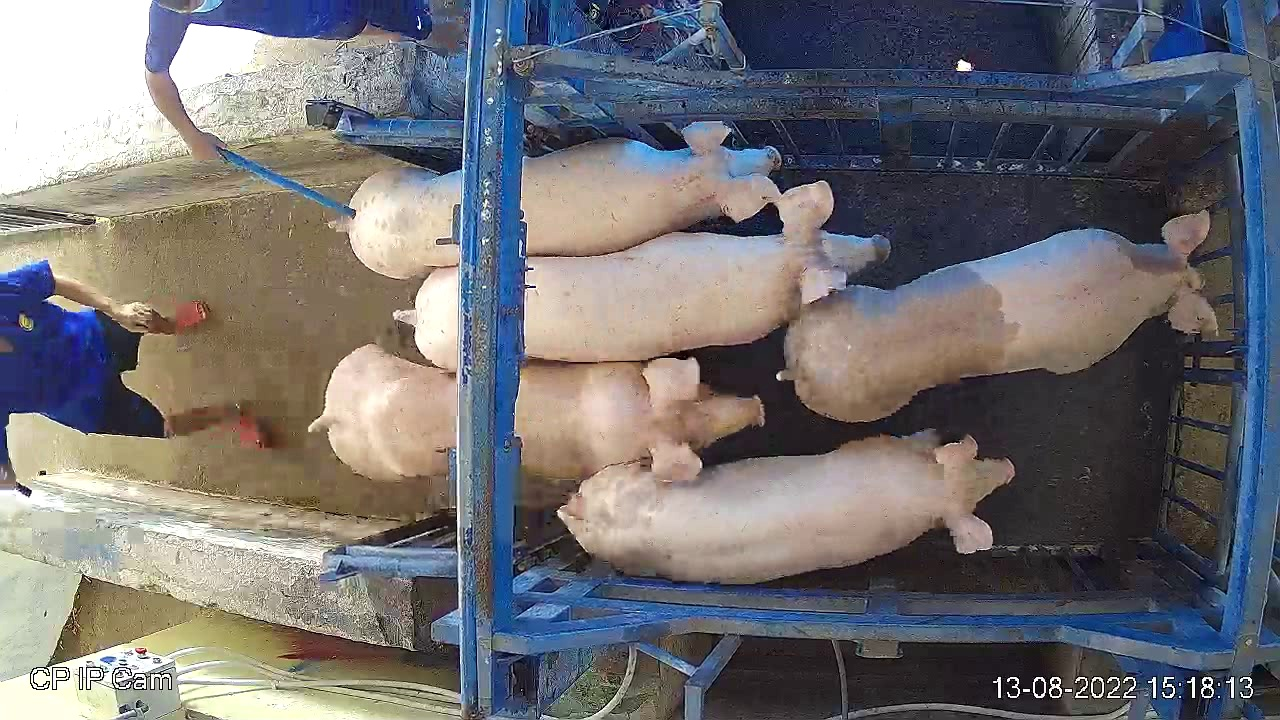

In [1]:
# Importing required libraries
import os
import numpy as np
from PIL import Image
from IPython.display import display

# Assuming these custom modules are available in the same directory
from mechanisms.segmentation_pipe import load_model, ground_image, sam_seg_rects
import torch

# Global variable
CURRENTLY_POSITIVE = True
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2

def load_sam_model(sam2_checkpoint = "checkpoints/sam2_hiera_large.pt"):
    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    if torch.cuda.get_device_properties(0).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        
    model_cfg = "sam2_hiera_l.yaml"
    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
    return sam2_model

# Function to perform box segmentation
def box_segment(image, text_prompt, box_threshold, text_threshold):
    config_file = "./gd_configs/grounding_dino_config.py"
    checkpoint_path = "./checkpoints/groundingdino_swint_ogc.pth"
    
    model = load_model(config_file, checkpoint_path).eval().to("cpu")
    
    image = image.convert("RGB")
    image_with_box, size, boxes_filt, pred_phrases, pred_dict = ground_image(model, text_prompt, image, box_threshold, text_threshold)
    
    return image_with_box, pred_dict

# Function to create mask and cutout
def create_mask_and_cutout(image, mask, color=(255, 255, 255)):
    h, w = mask.shape[-2:]
    
    mask_image = Image.fromarray(np.uint8(mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)))
    mask_gray = Image.fromarray(np.uint8(mask.reshape(h, w) * 255), mode='L')
    
    masked_image = Image.fromarray(np.array(image))
    masked_image_np = np.array(masked_image)
    masked_image_np[mask.reshape(h, w) == 0] = 0
    masked_cutout = Image.fromarray(masked_image_np)
    
    return mask_gray, masked_cutout

# Function to perform segmentation
def segment(image, pred_dict, points, labels):
    boxes = pred_dict["boxes"]
    
    sam2_model = load_sam_model("./checkpoints/sam2_hiera_large.pt")
    predictor = SAM2ImagePredictor(sam2_model)
    all_masks = sam_seg_rects(predictor, points, labels, image, boxes)
    
    output_masks = []
    output_cutouts = []
    for mask in all_masks:
        masked_item, cutout = create_mask_and_cutout(image, mask)
        output_masks.append(masked_item)
        output_cutouts.append(cutout)
    return output_cutouts

# Main execution in Jupyter notebook cells

# Cell 1: Load and display the image
image_path = "275.jpg"  # Replace with your image path
image = Image.open(image_path)
display(image)



In [2]:
# Cell 2: Get text prompt and thresholds from user
text_prompt = "pig"
box_threshold = 0.3
text_threshold = 0.3

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

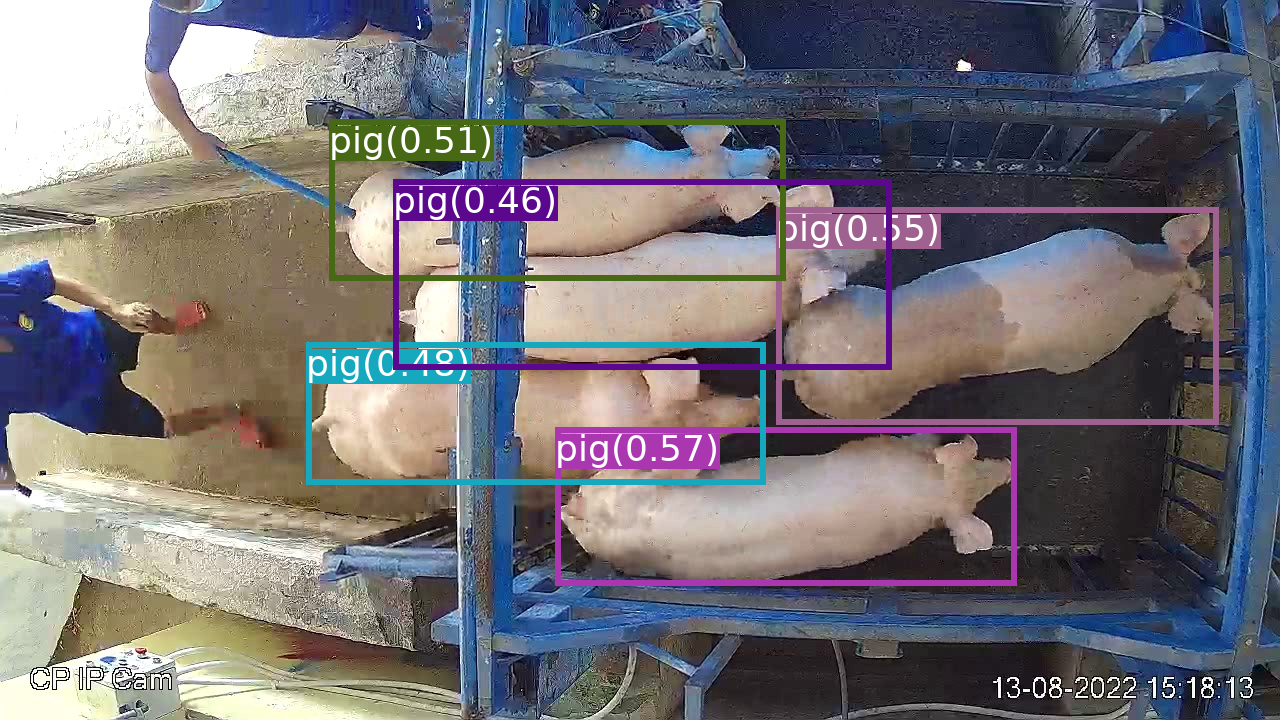

In [3]:
# Cell 3: Perform box segmentation
image_with_box, pred_dict = box_segment(image, text_prompt, box_threshold, text_threshold)
display(image_with_box)


In [4]:
sam2_model = load_sam_model("./checkpoints/sam2_hiera_large.pt")
predictor = SAM2ImagePredictor(sam2_model)
all_masks = sam_seg_rects(
    predictor, 
    None,
    None,
    image, 
    pred_dict['boxes'])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
import numpy as np
from PIL import Image

def create_masks_and_inpaint(image, masks, color=(0, 0, 0)):
    if not isinstance(masks, list):
        raise ValueError("Input 'masks' should be a list of mask arrays")

    image_np = np.array(image)
    h, w = image_np.shape[:2]
    
    # Create a combined mask
    combined_mask = np.zeros((h, w), dtype=bool)
    for mask in masks:
        # Remove single-dimensional entries from the shape of an array
        mask = np.squeeze(mask)
        
        if mask.shape != (h, w):
            raise ValueError(f"Mask shape {mask.shape} does not match image shape {(h, w)}")
        
        combined_mask |= mask.astype(bool)
    
    # Create the mask image
    mask_image = Image.fromarray(np.uint8(combined_mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)))
    
    # Create the grayscale mask
    mask_gray = Image.fromarray(np.uint8(combined_mask * 255), mode='L')
    
    # Create the inpainted image
    inpainted_image_np = image_np.copy()
    
    # Inpaint the masked regions with white
    inpainted_image_np[combined_mask] = color
    
    inpainted_result = Image.fromarray(inpainted_image_np)
    
    return mask_gray, inpainted_result

In [6]:
_, cutouts = create_masks_and_inpaint(image, all_masks)

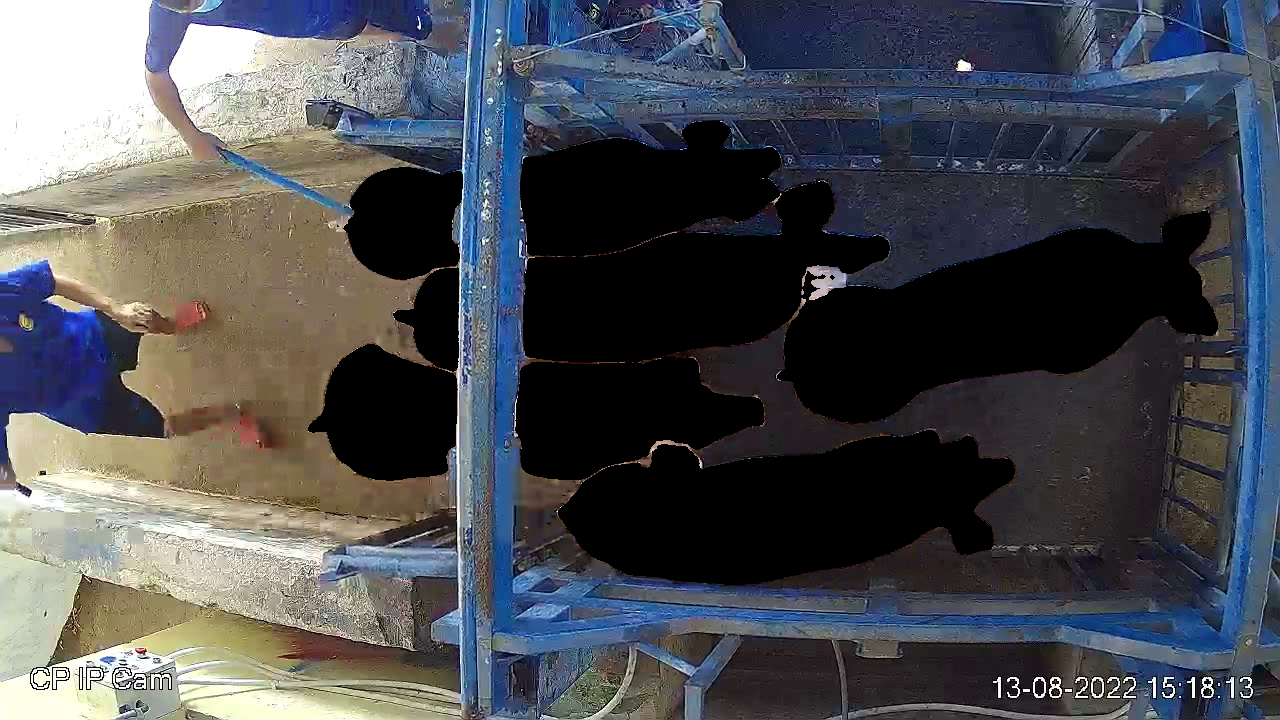

In [7]:
display(cutouts)

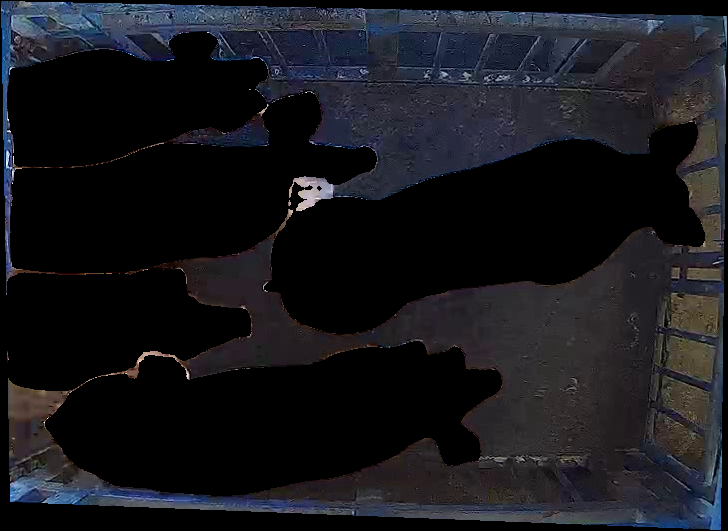

In [9]:
from PIL import Image, ImageDraw


# Define the polygon coordinates
poly = [
    (513, 89),
    (1240, 104),
    (1234, 619),
    (522, 591)
]
# Create a mask image with the same size as the original image, filled with black (0)
mask = Image.new('L', image.size, 0)

# Create a draw object to draw on the mask
draw = ImageDraw.Draw(mask)

# Draw the polygon on the mask, filling it with white (255)
draw.polygon(poly, outline=1, fill=255)

# Create a new image that will contain the cropped region
result = Image.new("RGB", cutouts.size)

# Paste the original image onto the result image, using the mask to only keep the polygon area
result.paste(cutouts, mask=mask)

# Crop the image to the bounding box of the polygon for a tighter fit
cropped = result.crop(mask.getbbox())
display(cropped)

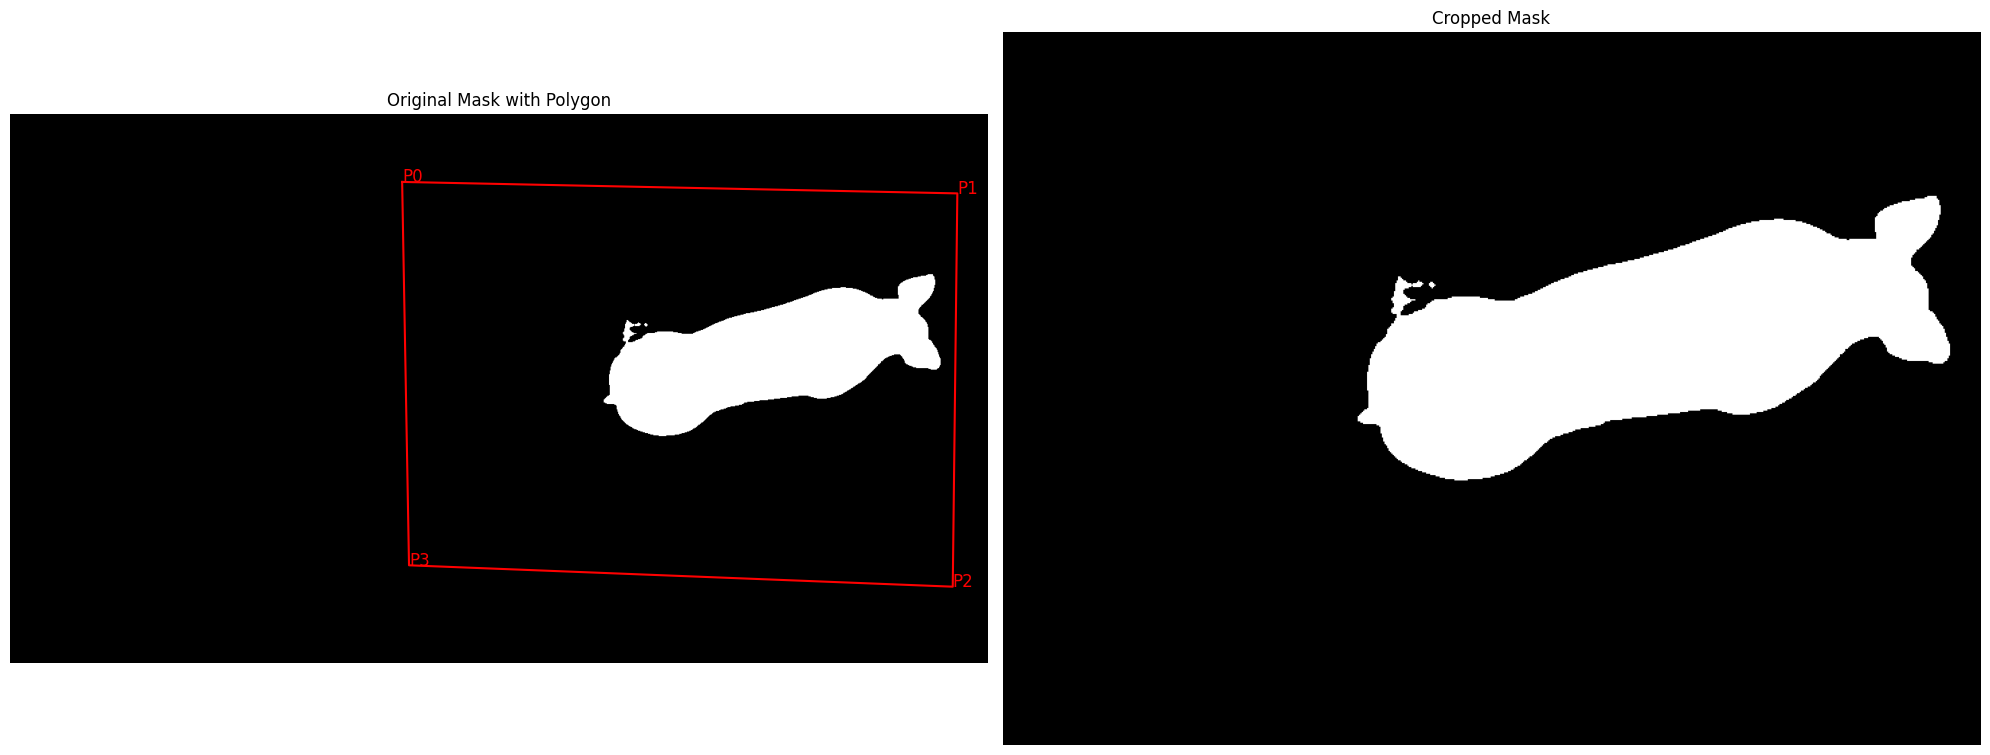

Bounding box (left, top, right, bottom): (513, 89, 1240, 619)
Cropped mask shape: (531, 728)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def crop_to_polygon(input_mask, poly):
    assert input_mask.shape == (1, 720, 1280), "Input mask must have shape (1, 720, 1280)"
    
    # Remove the singleton dimension
    mask = input_mask[0]
    
    # Create a new mask for the polygon
    polygon_mask = Image.new('L', (1280, 720), 0)
    ImageDraw.Draw(polygon_mask).polygon(poly, outline=1, fill=255)
    polygon_mask = np.array(polygon_mask)
    
    # Apply the polygon mask
    masked = mask * (polygon_mask > 0)
    
    # Find the bounding box of the polygon
    y_coords, x_coords = np.where(polygon_mask > 0)
    top = y_coords.min()
    bottom = y_coords.max()
    left = x_coords.min()
    right = x_coords.max()
    
    # Crop the masked image to the bounding box
    cropped = masked[top:bottom+1, left:right+1]
    
    return cropped, (left, top, right, bottom)

# Generate a sample input mask (you would replace this with your actual input)
input_mask = all_masks[0]

# Define the polygon
poly = [(513, 89), (1240, 104), (1234, 619), (522, 591)]

# Crop the mask to the polygon
cropped_mask, bbox = crop_to_polygon(input_mask, poly)

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Original mask with polygon
ax1.imshow(input_mask[0], cmap='gray')
ax1.plot([p[0] for p in poly + [poly[0]]], [p[1] for p in poly + [poly[0]]], 'r-')
for i, (x, y) in enumerate(poly):
    ax1.text(x, y, f'P{i}', color='red', fontsize=12)
ax1.set_title('Original Mask with Polygon')
ax1.axis('off')

# Cropped mask
ax2.imshow(cropped_mask, cmap='gray')
ax2.set_title('Cropped Mask')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Bounding box (left, top, right, bottom): {bbox}")
print(f"Cropped mask shape: {cropped_mask.shape}")

In [16]:
all_cropped_masks = [crop_to_polygon(mask, poly)[0] for mask in all_masks]

In [17]:
all_cropped_masks[0].shape

(531, 728)

In [18]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


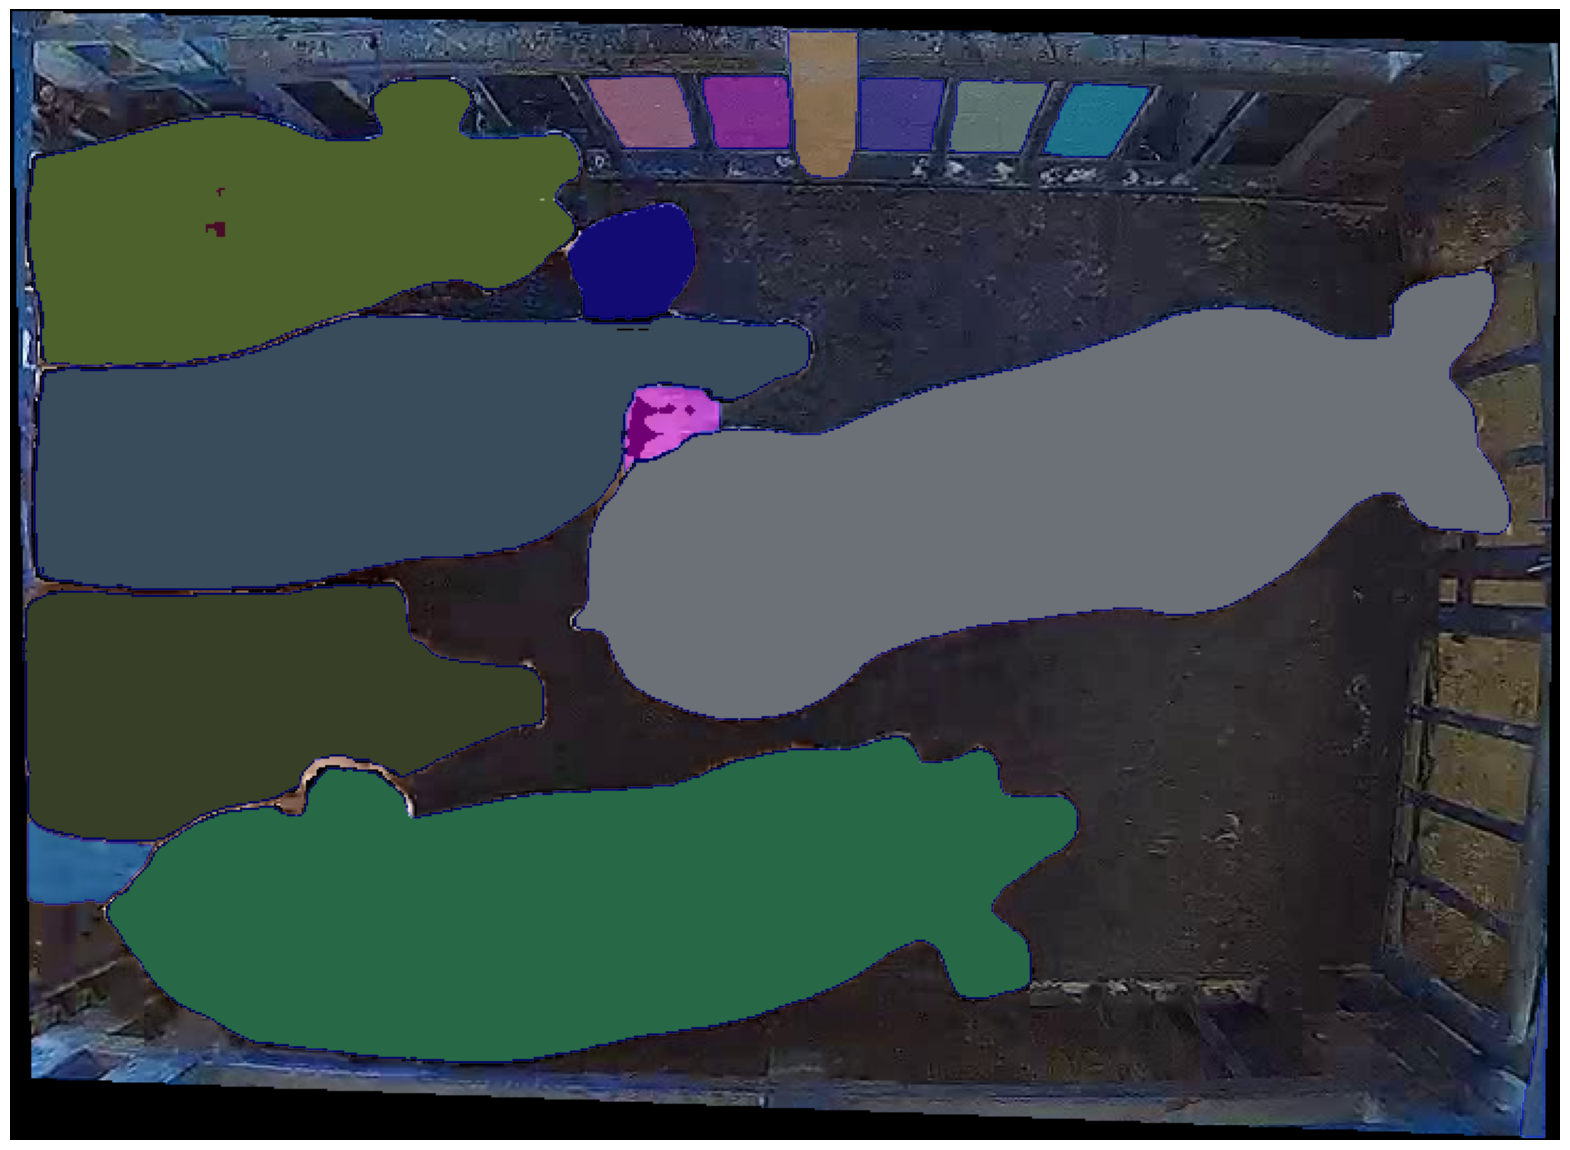

In [19]:
import matplotlib.pyplot as plt
masks = mask_generator.generate(np.array(cropped.convert("RGB")))

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1) 

    ax.imshow(img)
    
plt.figure(figsize=(20,20))
plt.imshow(cropped)
show_anns(masks)
plt.axis('off')
plt.show() 

In [22]:
def check_mask_overlap(mask1, mask2, threshold=0.95):
     """
     Check if the overlap between two masks is more than 95%.
     
     Parameters:
     mask1 (numpy.ndarray): First binary mask.
     mask2 (numpy.ndarray): Second binary mask.
     
     Returns:
     bool: True if the overlap is more than 95%, False otherwise.
     """
     if mask1.shape != mask2.shape:
          raise ValueError("Masks must have the same shape")

     # Calculate the intersection and union
     intersection = np.logical_and(mask1, mask2)
     intersection_area = np.sum(intersection)
     
     mask1_area = np.sum(mask1)
     mask2_area = np.sum(mask2)

     # Calculate overlap percentage
     overlap_percentage = intersection_area / min(mask1_area, mask2_area)
    
     return overlap_percentage > threshold

In [50]:
from copy import deepcopy
def process_multiple_masks(all_cropped_masks, object_masks):
     non_overlapping_masks = deepcopy(object_masks)
     for pig_mask in all_cropped_masks:
          for idx, obj_mask in enumerate(non_overlapping_masks):
               if check_mask_overlap(pig_mask, obj_mask['segmentation']):
                    # Remove the overlapping mask
                    del non_overlapping_masks[idx]
                    break
     return non_overlapping_masks
non_overlapping_masks = process_multiple_masks(all_cropped_masks, masks)

In [51]:
len(non_overlapping_masks)

11

In [52]:
len(all_cropped_masks)

5